# File for understanding data

In [ ]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

games = pd.read_csv("~/nfl-data-bowl/Sample_Data/Raw/games.csv")
plays = pd.read_csv("~/nfl-data-bowl/Sample_Data/Raw/plays.csv")
players = pd.read_csv("~/nfl-data-bowl/Sample_Data/Raw/players.csv")
player_play = pd.read_csv("~/nfl-data-bowl/Sample_Data/Raw/player_play.csv")

'''weeks = {}
for i in range(1, 10):
    file_path = f"~/nfl-data-bowl/Sample_Data/Raw/tracking_week_{i}.csv" 
    weeks[i] = pd.read_csv(file_path)'''

conn = sqlite3.connect(":memory:")

games.to_sql("games", conn, index=False, if_exists="replace")
plays.to_sql("plays", conn, index=False, if_exists="replace")
player_play.to_sql("player_play", conn, index=False, if_exists="replace")
players.to_sql("players", conn, index=False, if_exists="replace")

1697

#### How EPA affects whether a play is confused/not confused

In [8]:
epa_query = """
    SELECT pp.yardsGained, pp.expectedPointsAdded
    FROM plays pp
    JOIN games g ON pp.gameId = g.gameId
    WHERE g.week = 1 AND passResult != "IN" AND pp.penaltyYards IS NULL
"""
epa_results = pd.read_sql(epa_query, conn)
print(epa_results.shape)

epa_plays_q = """
    SELECT pp.gameId, pp.playId, pp.yardsGained
    FROM plays pp
    JOIN games g ON pp.gameId = g.gameId
    WHERE g.week = 1 AND (pp.expectedPointsAdded BETWEEN 3 AND 4) AND (pp.yardsGained BETWEEN 0 AND 10) AND pp.penaltyYards IS NULL
"""
epa_plays = pd.read_sql(epa_plays_q, conn)
print(epa_plays.head)

print(plays.shape)

(1159, 2)
<bound method NDFrame.head of        gameId  playId  yardsGained
0  2022091104    1041            1
1  2022091104    2047            7>
(15740, 50)


In [5]:
epa_plays_q = """
    SELECT AVG(pp.expectedPointsAdded)
    FROM plays pp
    JOIN games g ON pp.gameId = g.gameId
"""

epa_plays = pd.read_sql(epa_plays_q, conn)
print(epa_plays)

   AVG(pp.expectedPointsAdded)
0                    -0.029381


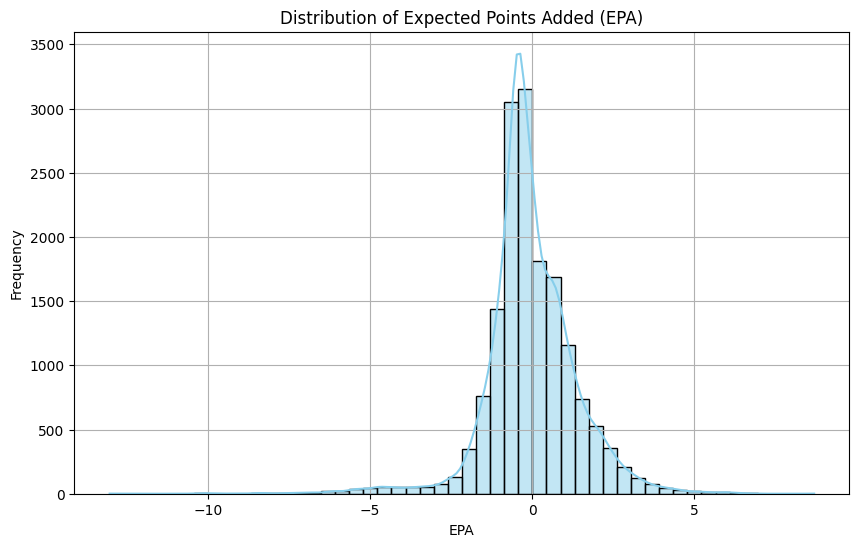

In [11]:
import seaborn as sns

epa = plays['expectedPointsAdded'].dropna()

# Plot histogram + KDE
plt.figure(figsize=(10, 6))
sns.histplot(epa, kde=True, bins=50, color='skyblue')
plt.title("Distribution of Expected Points Added (EPA)")
plt.xlabel("EPA")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

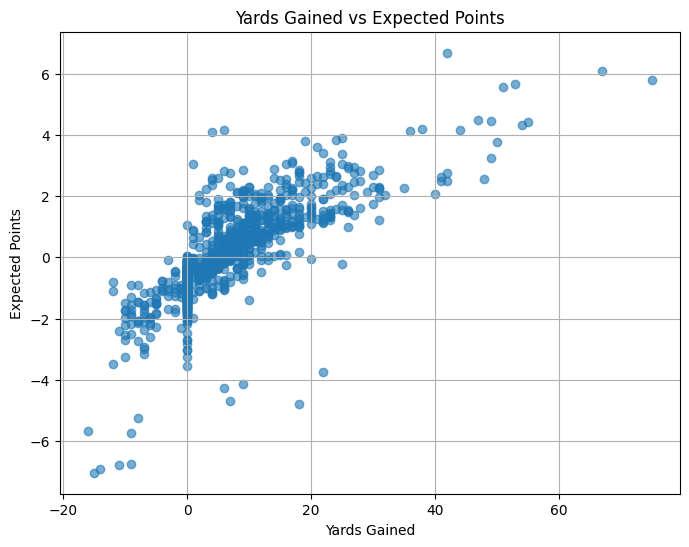

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(epa_results['yardsGained'], epa_results['expectedPointsAdded'], alpha=0.6)

# Labeling
plt.xlabel("Yards Gained")
plt.ylabel("Expected Points")
plt.title("Yards Gained vs Expected Points")
plt.grid(True)

# Show plot
plt.show()

#### If you want even groups

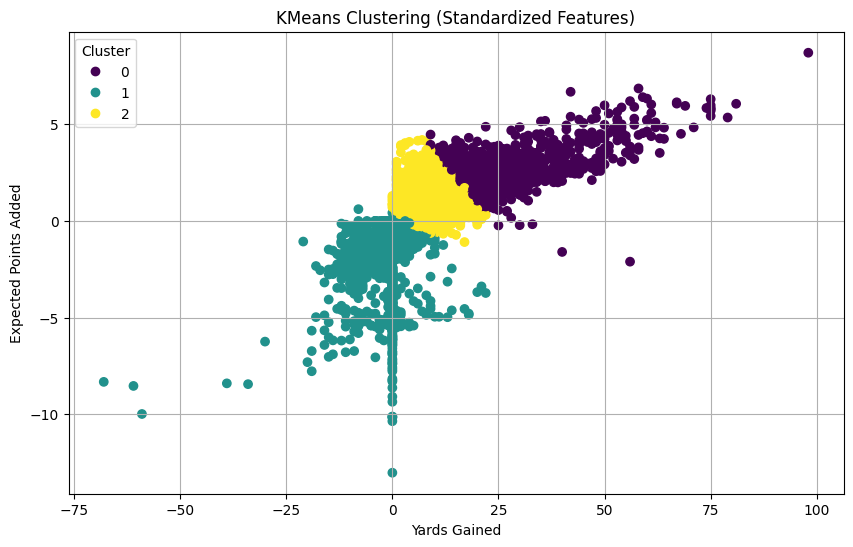

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

plays = plays[plays['penaltyYards'].isna()]
 
X = plays[['yardsGained', 'expectedPointsAdded']].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

X['Cluster'] = clusters

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X['yardsGained'], X['expectedPointsAdded'], c=X['Cluster'], cmap='viridis')
plt.xlabel("Yards Gained")
plt.ylabel("Expected Points Added")
plt.title("KMeans Clustering (Standardized Features)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.grid(True)
plt.show()

plt.show()


In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Load and filter plays
plays = pd.read_csv("~/nfl-data-bowl/Sample_Data/Raw/plays.csv")
plays = plays[plays['penaltyYards'].isna()]

# Select valid rows for clustering (dropna on needed features)
X = plays[['yardsGained', 'expectedPointsAdded']].dropna()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Assign clusters to X
X = X.copy()
X['Cluster'] = clusters

# Reorder clusters so 0 = not confused, 1 = normal, 2 = confused
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
scores = cluster_centers[:, 1] + 0.2 * cluster_centers[:, 0]  # EPA + 0.2 * Yards
remap = {old: new for new, old in enumerate(np.argsort(scores))}
X['ConfusionLabel'] = X['Cluster'].map(remap)

# Assign back to original plays using index
plays.loc[X.index, 'isConfused'] = X['ConfusionLabel']

# Sanity check
print(plays['isConfused'].value_counts())

# Save
plays[['gameId', 'playId', 'isConfused']].to_csv(
    "~/nfl-data-bowl/Sample_Data/Processed/ConfusedPlays_KMeans.csv",
    index=False
)


isConfused
0.0    8448
1.0    6110
2.0    1182
Name: count, dtype: int64
